In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Parameters
num_projects = 1000
project_types = ['Residential', 'Commercial', 'Infrastructure']
locations = ['North', 'South', 'East', 'West']
complexity_levels = ['Low', 'Medium', 'High']

# Generate synthetic data
data = []
for i in range(1, num_projects + 1):
    project_id = f'P{i:04d}'
    project_type = random.choice(project_types)
    location = random.choice(locations)
    start_date = datetime(2015, 1, 1) + timedelta(days=random.randint(0, 365 * 5))
    duration_days = random.randint(180, 730)  # Project duration between 6 months to 2 years
    end_date = start_date + timedelta(days=duration_days)
    total_floor_area = round(random.uniform(500, 50000), 2)  # Floor area between 500 to 50,000 sqm
    num_floors = random.randint(1, 50)
    material_cost_index = round(random.uniform(100, 200), 2)
    labor_cost_index = round(random.uniform(100, 200), 2)
    project_complexity = random.choice(complexity_levels)
    
    # Simulate project cost based on features
    base_cost = total_floor_area * 1500  # Base cost per sqm
    complexity_multiplier = {'Low': 1.0, 'Medium': 1.2, 'High': 1.5}[project_complexity]
    cost_adjustment = (material_cost_index / 150) * (labor_cost_index / 150)
    total_cost = base_cost * complexity_multiplier * cost_adjustment
    total_cost = round(total_cost, 2)
    
    data.append([
        project_id, project_type, location, start_date, end_date,
        total_floor_area, num_floors, material_cost_index,
        labor_cost_index, project_complexity, total_cost
    ])

# Create DataFrame
columns = [
    'Project ID', 'Project Type', 'Location', 'Start Date', 'End Date',
    'Total Floor Area (sqm)', 'Number of Floors', 'Material Cost Index',
    'Labor Cost Index', 'Project Complexity', 'Total Cost'
]
df = pd.DataFrame(data, columns=columns)

# Display the first few rows
print(df.head())


  Project ID    Project Type Location Start Date   End Date  \
0      P0001  Infrastructure    North 2015-02-21 2016-05-27   
1      P0002     Residential     West 2015-03-07 2015-10-03   
2      P0003  Infrastructure     West 2016-03-27 2017-12-26   
3      P0004      Commercial     East 2015-11-15 2016-12-19   
4      P0005      Commercial     East 2019-07-11 2020-02-20   

   Total Floor Area (sqm)  Number of Floors  Material Cost Index  \
0                12622.15                 9               173.65   
1                 5137.91                15               150.54   
2                29668.65                 1               175.88   
3                47882.05                22               110.22   
4                36621.72                35               112.48   

   Labor Cost Index Project Complexity   Total Cost  
0            167.67               High  36750520.04  
1            102.65                Low   5293051.25  
2            115.97             Medium  48411650.1

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convert categorical variables to numerical
df['Project Complexity'] = df['Project Complexity'].map({'Low': 1, 'Medium': 2, 'High': 3})

# Calculate project duration in days
df['Duration Days'] = (df['End Date'] - df['Start Date']).dt.days

In [3]:
# Select features and target variable
features = [
    'Project Type', 'Location', 'Total Floor Area (sqm)', 'Number of Floors',
    'Material Cost Index', 'Labor Cost Index', 'Project Complexity', 'Duration Days'
]
target = 'Total Cost'

In [4]:
X = df[features]
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Preprocessing pipelines for both numeric and categorical data
numeric_features = ['Total Floor Area (sqm)', 'Number of Floors', 'Material Cost Index', 'Labor Cost Index', 'Project Complexity', 'Duration Days']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['Project Type', 'Location']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [6]:
# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 4517342.4831685005
Root Mean Squared Error: 6353945.153823069


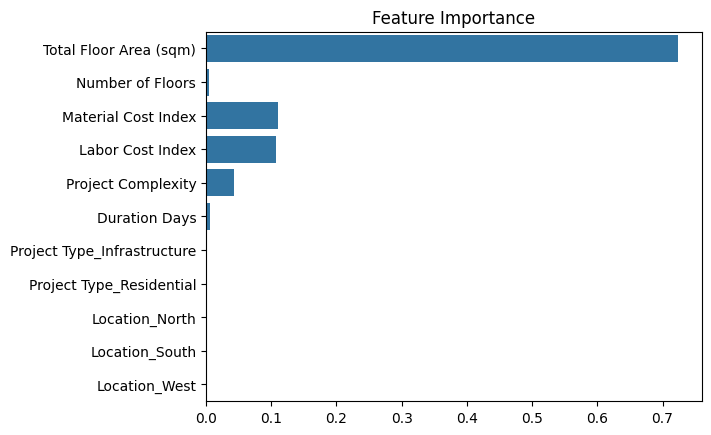

/var/folders/th/55hfqgh912325b89wjzp3d_w0000gn/T/ipykernel_5992/2642617888.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')


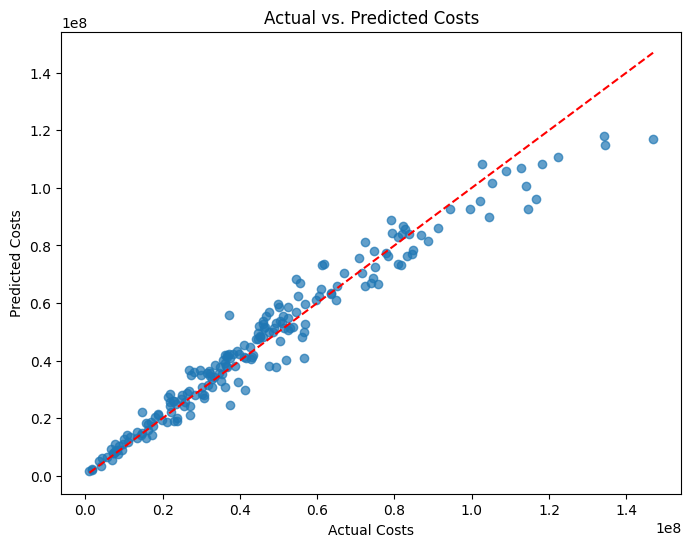

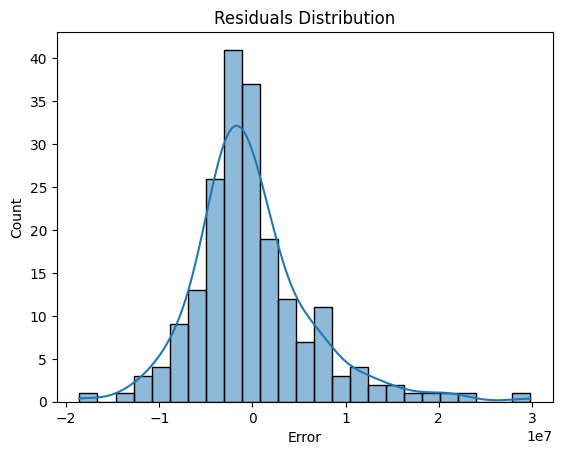

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance
importance = model.named_steps['regressor'].feature_importances_
feature_names = preprocessor.transformers_[0][2] + list(
    preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out()
)
sns.barplot(x=importance, y=feature_names)
plt.title('Feature Importance')
plt.show()

# Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red')
plt.xlabel('Actual Costs')
plt.ylabel('Predicted Costs')
plt.title('Actual vs. Predicted Costs')
plt.show()

# Residuals
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Error')
plt.show()
